# Libraries

In [1]:
from google.colab import drive
drive.mount ('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install split-folders

In [3]:
!pip install seaborn

In [4]:

## Directories
import random
import shutil
##
import pandas as pd
import numpy as np
import os

## Graphs
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
# TensorFlow
import tensorflow as tf
from tensorflow.keras import models, layers
# Keras
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# Image processing
from keras.preprocessing import image
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
# Time
import time

In [5]:
# Dictionary to save our 26 classes
categories = {
    0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H", 8: "I", 9: "J",
    10: "K", 11: "L", 12: "M", 13: "N", 14: "O", 15: "P", 16: "Q", 17: "R", 18: "S",
    19: "T", 20: "U", 21: "V", 22: "W", 23: "X", 24: "Y", 25: "Z"
}

def add_class_name_prefix(df, col_name):
    df['Numerical_Label'] = df[col_name].map({v: k for k, v in categories.items()})
    return df

# Your base path containing folders for each class (A-Z)
base_path = '/content/drive/MyDrive/Project_Deep_Learning /Images_Folder'  # Update with your actual path

# List containing all the filenames in the dataset
filenames_list = []
# List to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(os.path.join(base_path, categories[category]))
    filenames_list += filenames
    categories_list += [categories[category]] * len(filenames)

# Create a DataFrame
df = pd.DataFrame({"filename": filenames_list, "category": categories_list})

# Add numerical labels to the DataFrame
df = add_class_name_prefix(df, "category")

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)


In [6]:
df

,filename,category,Numerical_Label
0,WIN_20231226_14_47_17_Pro (2).jpg,V,21
1,WIN_20231224_18_31_43_Pro (2).jpg,D,3
2,WIN_20231226_14_48_57_Pro.jpg,Y,24
3,E.jpg,E,4
4,Captura de ecrã 2023-12-19 134407.png,I,8
...,...,...,...
9265,WIN_20231220_08_58_21_Pro.jpg,E,4
9266,WIN_20231226_22_49_08_Pro.jpg,P,15
9267,WIN_20231224_18_38_56_Pro.jpg,M,12
9268,WIN_20231221_15_59_42_Pro.jpg,J,9


In [7]:
filename_counts = df['category'].value_counts().sort_index()

# Display the result
filename_counts


A    411
B    377
C    357
D    368
E    350
F    371
G    351
H    391
I    329
J    362
K    347
L    359
M    366
N    345
O    348
P    354
Q    330
R    365
S    361
T    352
U    337
V    352
W    328
X    363
Y    336
Z    360
Name: category, dtype: int64

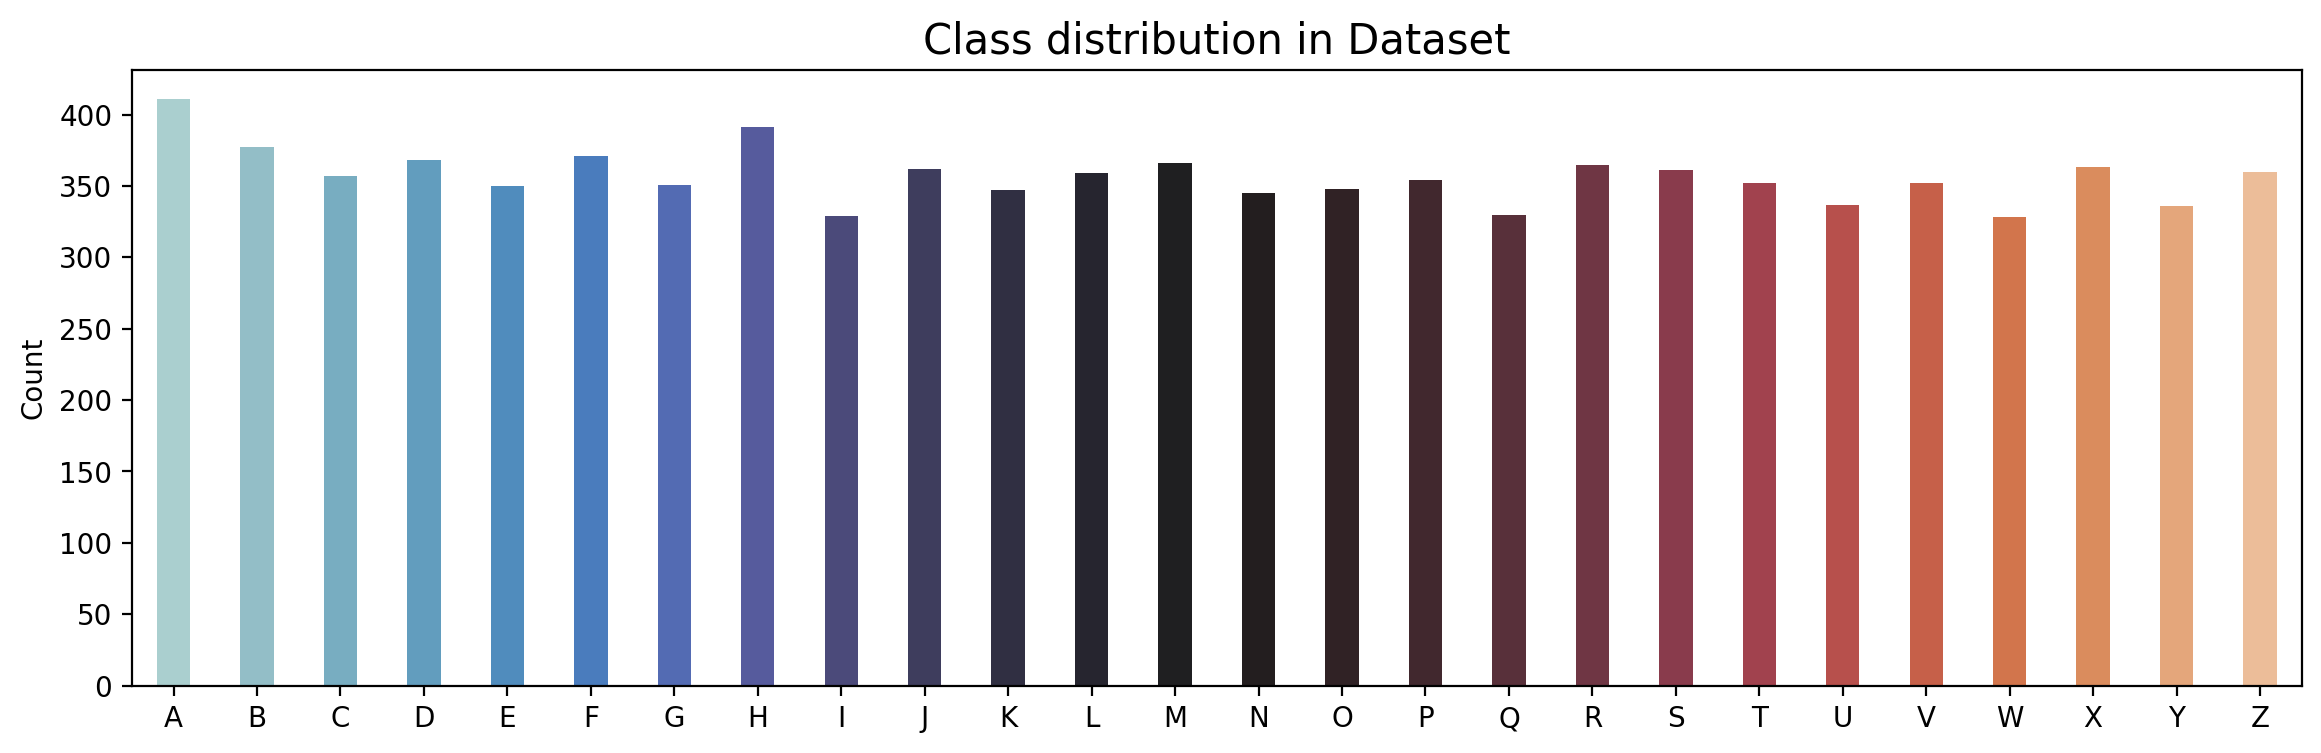

In [8]:
label,count = np.unique(df.category,return_counts=True)
uni = pd.DataFrame(data=count,index=categories.values(),columns=['Count'])

plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)
plt.show()

In [ ]:
#%run /content/drive/MyDrive/DLNN/Functions.ipynb

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<a id='6'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Train Test Split </h2> </div>

We will split the data in three parts.
* Training dataset (70%)
* Validation dataset (15%)
* Testing dataset (15%)

In [ ]:
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/Project_Deep_Learning /Images_Folder", output="/content/drive/MyDrive/Project_Deep_Learning /output", seed=1337, ratio=(0.7, 0.15,0.15))

Copying files: 9270 files [03:36, 42.90 files/s]


# Augmentation

In [ ]:
#datagen = ImageDataGenerator(rescale= 1.0 / 255)

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest', # Strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.
    rescale=1./255, # Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
    horizontal_flip=False
)

In [10]:
train_path = '/content/drive/MyDrive/Project_Deep_Learning /output/train'
val_path = '/content/drive/MyDrive/Project_Deep_Learning /output/val'
test_path = '/content/drive/MyDrive/Project_Deep_Learning /output/test'

batch = 32
image_size = 150
img_channel = 3
n_classes = 26

In [11]:
train_data = train_datagen.flow_from_directory(directory= train_path,
                                         target_size=(image_size,image_size),
                                         batch_size = batch,
                                         class_mode='categorical')

val_data = train_datagen.flow_from_directory(directory= val_path,
                                       target_size=(image_size,image_size),
                                       batch_size = batch,
                                       class_mode='categorical',
                                       )

test_data = train_datagen.flow_from_directory(directory= test_path,
                                         target_size=(image_size,image_size),
                                         batch_size = batch,
                                         class_mode='categorical',
                                         shuffle= False)

Found 6473 images belonging to 26 classes.
Found 1378 images belonging to 26 classes.
Found 1419 images belonging to 26 classes.


# Modeling

In [12]:
num_of_classes = len(categories)
num_of_classes

26

In [13]:
# Your existing CNN layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_of_classes, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [14]:
early_stoping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [15]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc'])

In [ ]:
history = model.fit(train_data,
                      validation_data= val_data,
                      epochs=100,
                      callbacks=[early_stoping],
                      verbose = 1)

Epoch 1/100
203/203 [==============================] - 1819s 9s/step - loss: 3.2502 - acc: 0.0522 - val_loss: 3.1783 - val_acc: 0.0776
Epoch 2/100
203/203 [==============================] - 104s 511ms/step - loss: 3.1078 - acc: 0.0901 - val_loss: 3.0263 - val_acc: 0.1016
Epoch 3/100
203/203 [==============================] - 103s 508ms/step - loss: 2.9327 - acc: 0.1302 - val_loss: 2.8820 - val_acc: 0.1350
Epoch 4/100
203/203 [==============================] - 101s 496ms/step - loss: 2.7808 - acc: 0.1685 - val_loss: 2.7297 - val_acc: 0.1836
Epoch 5/100
203/203 [==============================] - 99s 488ms/step - loss: 2.5081 - acc: 0.2412 - val_loss: 2.4823 - val_acc: 0.2409
Epoch 7/100
203/203 [==============================] - 102s 503ms/step - loss: 2.3747 - acc: 0.2813 - val_loss: 2.4500 - val_acc: 0.2700
Epoch 8/100
203/203 [==============================] - 101s 498ms/step - loss: 2.2609 - acc: 0.3056 - val_loss: 2.3008 - val_acc: 0.3120
Epoch 9/100
203/203 [=======================

# Prediction

In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory=r"/content/Output/test",
    target_size=(150, 150),
    batch_size=20,
    class_mode="categorical",
    #classes=letters,
    shuffle=False,
    seed=42
)

In [ ]:
count_images_generator(test_generator)

In [ ]:
images_pred, labels_pred = next(test_generator)  # Load a batch of images and labels
plt.imshow(image.array_to_img(images_pred[9]))

In [ ]:
pred = model.predict(test_generator)
results = np.argmax(pred,axis=-1)
mapped_results = [mapping_dict.get(item) for item in results]

In [ ]:
expected = []
for i in range(len(letters)):
    for j in range(test_letter_count[i]):
        expected.append(letters[i])

## Classification Report

In [ ]:
print(classification_report(expected, mapped_results, target_names=letters))

## Confusion Matrix

In [ ]:
def draw_confusion_matrix(true, preds):
   conf_matx = confusion_matrix(true, preds)
   sns.heatmap(
      conf_matx,
      annot=True,
      annot_kws={"size": 12},
      fmt='g',
      cbar=False,
      cmap="viridis",
      xticklabels=letters,
      yticklabels=letters

   )
   plt.show()

In [ ]:

draw_confusion_matrix(expected, mapped_results)

## Prediction Analysis

In [ ]:
array_prediction=np.array([expected,mapped_results]).T
df_prediction=pd.DataFrame(array_prediction, columns=['Expected','Predicted'])
df_prediction

# Save log
May not save the model due to it's size

In [ ]:
# May not save the model due to it's size
save_model_log()

# Move back

In [ ]:
for letter in letters:
    for dataset in datasets:
        source_dir = os.path.join(main_directory, dataset, letter)
        files = os.listdir(source_dir)
        for file in files:
            dest = os.path.join(main_directory, letter, file)
            shutil.move(os.path.join(source_dir, file), dest)